In [111]:
import yfinance as yf
import pandas as pd
import numpy as np
# from qiskit.primitives import sampler    -> Will be Depreciated

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Sampler  
from qiskit_aer import Aer
from qiskit_aer import backends


In [112]:
#yf = yahoo finance
import yfinance as yf

#(NSE India stocks with .NS suffix)
stocks = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS", "TCS.NS", "ICICIBANK.NS", 
                   "HINDUNILVR.NS", "KOTAKBANK.NS", "LT.NS", "SBIN.NS", "AXISBANK.NS", 
                   "BAJFINANCE.NS", "BHARTIARTL.NS", "MARUTI.NS", "SUNPHARMA.NS", 
                   "TITAN.NS", "ULTRACEMCO.NS", "TATASTEEL.NS", "ASIANPAINT.NS", 
                   ]

# Download historical stock data for 3 years
df = yf.download(stocks, start="2021-01-01", end="2024-01-01")

#WE ARE USING ONLY THE CLOSE PRICE OF THE STOCKS
df = df['Close']
print(df.head())

[*********************100%***********************]  18 of 18 completed

Ticker      ASIANPAINT.NS  AXISBANK.NS  BAJFINANCE.NS  BHARTIARTL.NS  \
Date                                                                   
2021-01-01    2685.372314   621.093811    5204.156738     498.339722   
2021-01-04    2664.232178   621.989929    5141.127441     500.226074   
2021-01-05    2703.077881   661.567505    5045.326172     497.227264   
2021-01-06    2714.203857   651.411743    4957.902344     508.158508   
2021-01-07    2701.529297   668.188599    5007.873047     527.457520   

Ticker      HDFCBANK.NS  HINDUNILVR.NS  ICICIBANK.NS      INFY.NS  \
Date                                                                
2021-01-01  1368.017578    2245.106201    509.912445  1148.968262   
2021-01-04  1359.329712    2281.732666    513.972412  1174.309570   
2021-01-05  1369.601440    2304.347656    519.337341  1179.368896   
2021-01-06  1363.697510    2273.081543    528.472290  1168.703491   
2021-01-07  1359.569702    2227.522217    523.058899  1150.517944   

Ticker     

In [113]:
"""we are calculating the daily return and the covariance matrix , the matrix is imp cause it tells us if our portfolio is well balanced or not
if the covariance is high then the stocks are not well balanced and if the covariance is low then the stocks are well balanced"""

returns = df.pct_change()
mean_returns = returns.mean()
cov_mat = returns.cov()


In [124]:
#building the qubo matrix
import numpy as np
assets = len(stocks)
Q = np.zeros([assets, assets]) #init the qubo matrix
penalty  *= 0.5
for i in range(assets):
    Q[i,i] = -mean_returns[i]+penalty*cov_mat.iloc[i,i]
    for j in range(i+1, assets):
        Q[i,j] = -cov_mat.iloc[i,j]
        Q[j,i] = -cov_mat.iloc[i,j]

print(Q)   


[[ 9.17190514e-04 -4.08943812e-05 -8.77032909e-05 -4.03182683e-05
  -4.78850297e-05 -8.01247488e-05 -5.48812756e-05 -6.34749736e-05
  -5.19871789e-05 -6.51954840e-05 -6.94119745e-05 -4.99754690e-05
  -4.76779623e-05 -3.70621053e-05 -2.19014590e-05 -6.38405941e-05
  -8.88743389e-05 -8.26480243e-05]
 [-4.08943812e-05  7.07829828e-04 -1.33299603e-04 -7.39405515e-05
  -1.00214171e-04 -4.35491336e-05 -1.64342141e-04 -5.45653882e-05
  -1.07425594e-04 -9.59265810e-05 -8.32433085e-05 -8.52694855e-05
  -1.67443385e-04 -3.59694029e-05 -8.28745276e-05 -4.31956216e-05
  -8.61765373e-05 -8.47284538e-05]
 [-8.77032909e-05 -1.33299603e-04  1.47889430e-03 -8.26136206e-05
  -1.19680295e-04 -6.24914471e-05 -1.39694743e-04 -8.72512942e-05
  -1.26480535e-04 -1.11029221e-04 -9.35995830e-05 -1.11089995e-04
  -1.58685427e-04 -6.14105412e-05 -8.52243225e-05 -7.11393489e-05
  -1.22855723e-04 -1.10649392e-04]
 [-4.03182683e-05 -7.39405515e-05 -8.26136206e-05  1.67975413e-04
  -6.67055304e-05 -2.82302343e-05 -7.

C:\Users\Aditya Dwaraki Rao\AppData\Local\Temp\ipykernel_29372\1788375146.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q[i,i] = -mean_returns[i]+penalty*cov_mat.iloc[i,i]


In [125]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import BackendSampler

qubo = QuadraticProgram()
for i in range(assets):
    qubo.binary_var(f"x{i}")

linear_terms = {f"x{i}": Q[i, i] for i in range(assets)}
quadratic_terms = {(f"x{i}", f"x{j}"): Q[i, j] for i in range(assets) for j in range(i + 1, assets)}
qubo.minimize(linear=linear_terms, quadratic=quadratic_terms)

backend = Aer.get_backend('qasm_simulator')
sampler = Sampler() 
qaoa = QAOA(sampler=sampler, optimizer=COBYLA(), reps=10)

# Convert QUBO to Ising model (handled internally by MinimumEigenOptimizer)
meo = MinimumEigenOptimizer(qaoa)
result = meo.solve(qubo)  

print(result)
print("Optimal Portfolio Selection:", result.x)
print("Optimal Portfolio Value:", result.fval)

fval=-0.00011549804313384687, x0=0.0, x1=0.0, x2=0.0, x3=1.0, x4=0.0, x5=0.0, x6=1.0, x7=0.0, x8=0.0, x9=1.0, x10=0.0, x11=1.0, x12=1.0, x13=1.0, x14=0.0, x15=0.0, x16=1.0, x17=0.0, status=SUCCESS
Optimal Portfolio Selection: [0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0.]
Optimal Portfolio Value: -0.00011549804313384687


In [116]:
# import qiskit_optimization.applications
# help(qiskit_optimization.applications)

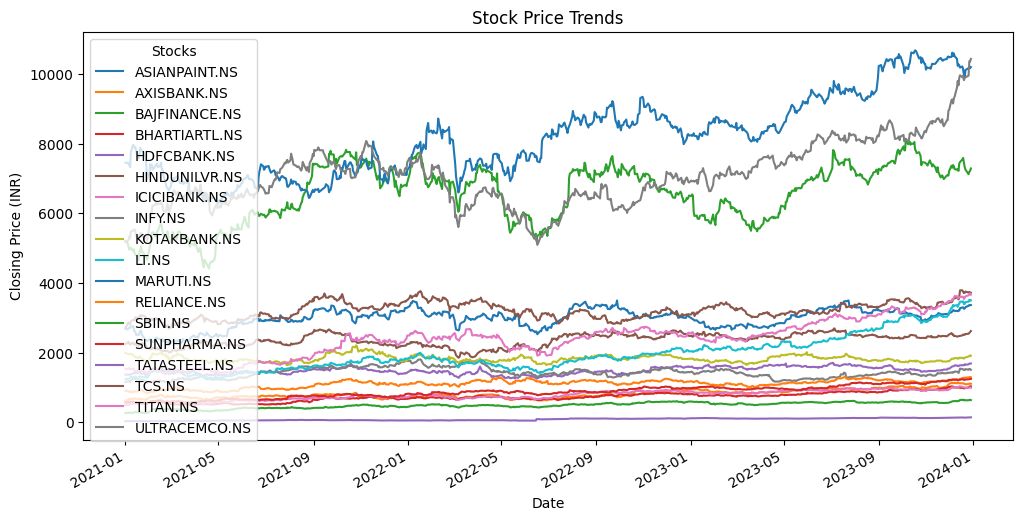

In [126]:
import matplotlib.pyplot as plt

# Plot stock closing prices over time
df.plot(figsize=(12,6), title="Stock Price Trends")
plt.xlabel("Date")
plt.ylabel("Closing Price (INR)")
plt.legend(title="Stocks")
plt.show()


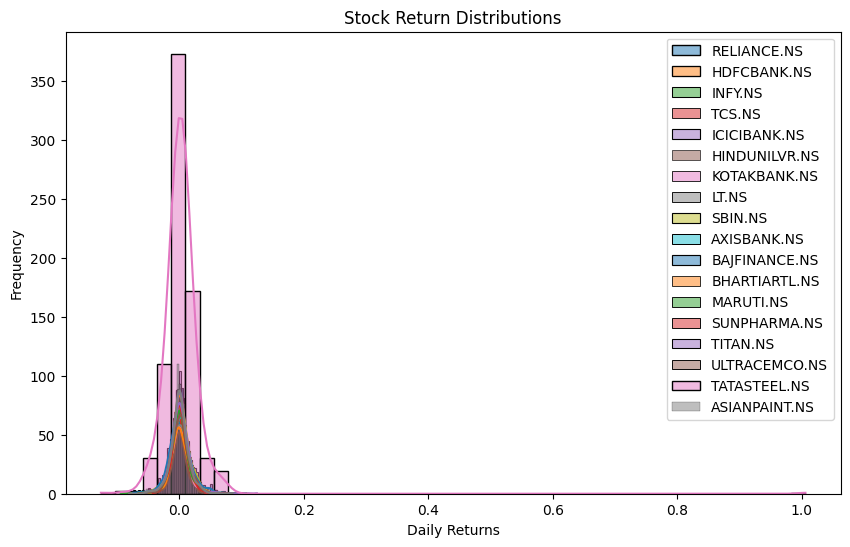

In [127]:
import seaborn as sns

# Plot return distributions for each stock
plt.figure(figsize=(10,6))
for stock in stocks:
    sns.histplot(returns[stock], kde=True, label=stock, bins=50)

plt.title("Stock Return Distributions")
plt.xlabel("Daily Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()


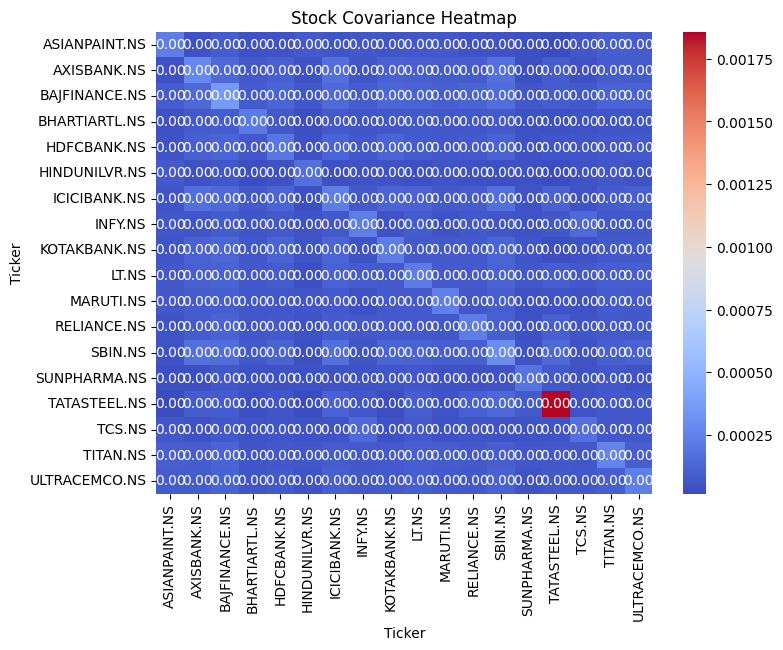

In [128]:
plt.figure(figsize=(8,6))
sns.heatmap(cov_mat, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Stock Covariance Heatmap")
plt.show()


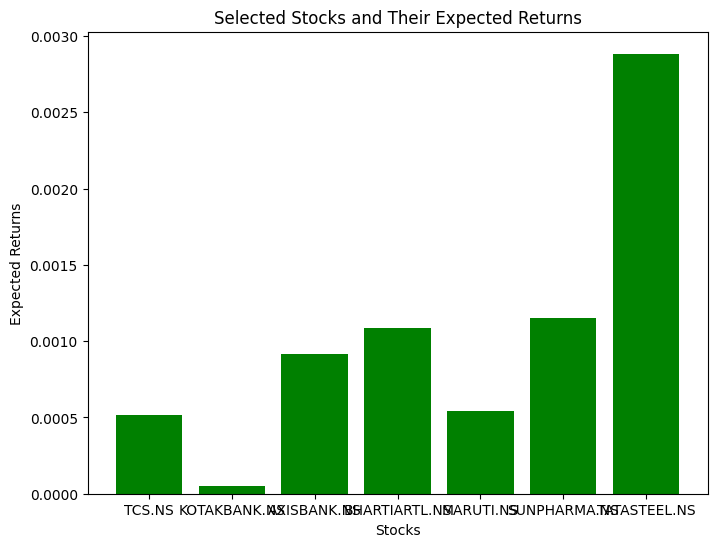

In [129]:
selected_stocks = [stocks[i] for i in range(len(stocks)) if result.x[i] == 1]

# Bar plot for selected stocks
plt.figure(figsize=(8,6))
plt.bar(selected_stocks, mean_returns[selected_stocks], color='green')
plt.title("Selected Stocks and Their Expected Returns")
plt.xlabel("Stocks")
plt.ylabel("Expected Returns")
plt.show()


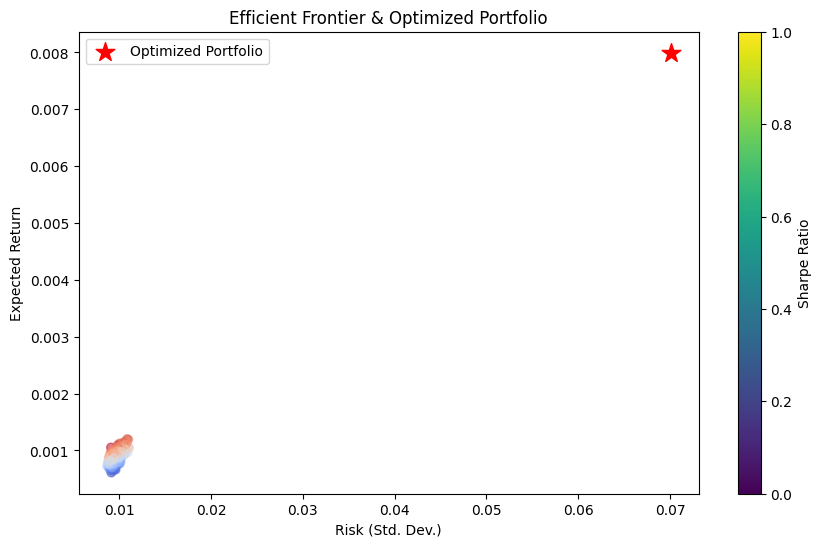

In [130]:
# Simulate random portfolios
num_portfolios = 1000
random_returns = []
random_risks = []

for _ in range(num_portfolios):
    weights = np.random.random(assets)
    weights /= np.sum(weights)  # Normalize to sum to 1
    port_return = np.dot(weights, mean_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    random_returns.append(port_return)
    random_risks.append(port_risk)

# Optimized portfolio values
opt_return = np.dot(result.x, mean_returns)
opt_risk = np.sqrt(np.dot(result.x.T, np.dot(cov_mat, result.x)))

# Plot Efficient Frontier
plt.figure(figsize=(10,6))
plt.scatter(random_risks, random_returns, c=random_returns/np.array(random_risks), cmap='coolwarm', alpha=0.5)
plt.scatter(opt_risk, opt_return, color='red', marker='*', s=200, label="Optimized Portfolio")
plt.xlabel("Risk (Std. Dev.)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier & Optimized Portfolio")
plt.legend()
plt.colorbar(label="Sharpe Ratio")
plt.show()


In [122]:
"""import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Qiskit Imports (Quantum Optimization)
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer import Aer
from qiskit_ibm_provider import IBMProvider

# Step 1: Download Historical Stock Data
stocks = ["TCS.NS", "INFY.NS", "HDFCBANK.NS", "RELIANCE.NS", "ITC.NS", "BAJFINANCE.NS"]
df = yf.download(stocks, start="2021-01-01", end="2024-01-01")['Close']

# Step 2: Calculate Returns & Covariance Matrix
returns = df.pct_change().dropna()
expected_returns = returns.mean()
cov_matrix = returns.cov()

# Step 3: Construct QUBO Matrix
assets = len(expected_returns)
Q = np.zeros((assets, assets))
penalty = 1 / np.mean(abs(cov_matrix.values))  # Adjust for risk-return balance

for i in range(assets):
    Q[i, i] = -expected_returns.iloc[i] + penalty * cov_matrix.iloc[i, i]
    for j in range(i + 1, assets):
        Q[i, j] = penalty * cov_matrix.iloc[i, j]
        Q[j, i] = Q[i, j]

# Step 4: Classical Optimization (Scipy)
def classical_solver(Q):
    def objective(x):
        return sum(Q[i, j] * x[i] * x[j] for i in range(assets) for j in range(assets))
    
    x0 = np.random.randint(0, 2, assets)  # Initial random binary solution
    bounds = [(0, 1) for _ in range(assets)]  # Binary constraint
    result = minimize(objective, x0, bounds=bounds, method='COBYLA')
    
    # Convert floating values to binary (0 or 1)
    x_opt = np.round(result.x).astype(int)
    return x_opt, result.fun

classical_solution, classical_value = classical_solver(Q)

# Step 5: Quantum Optimization (QAOA on IBMQ)
# Define QUBO problem for Qiskit
qubo = QuadraticProgram()
for i in range(assets):
    qubo.binary_var(f"x{i}")

linear_terms = {f"x{i}": Q[i, i] for i in range(assets)}
quadratic_terms = {(f"x{i}", f"x{j}"): Q[i, j] for i in range(assets) for j in range(i + 1, assets)}
qubo.minimize(linear=linear_terms, quadratic=quadratic_terms)

# Load IBMQ backend
provider = IBMProvider()
backend = provider.get_backend("ibmq_qasm_simulator")  # Change to real backend like 'ibmq_mumbai' if available

sampler = Aer.get_backend('aer_simulator')  # Local simulator for testing
qaoa = QAOA(sampler=sampler, optimizer=COBYLA(), reps=10)

meo = MinimumEigenOptimizer(qaoa)
qaoa_result = meo.solve(qubo)

qaoa_solution = np.array([int(qaoa_result.x[i]) for i in range(assets)])
qaoa_value = qaoa_result.fval

# Step 6: Print Results
print("\n===== Portfolio Optimization Results =====")
print("Classical Optimization:")
print("Selected Stocks:", [stocks[i] for i in range(assets) if classical_solution[i] == 1])
print("Objective Value:", classical_value)

print("\nQAOA Quantum Optimization (IBMQ):")
print("Selected Stocks:", [stocks[i] for i in range(assets) if qaoa_solution[i] == 1])
print("Objective Value:", qaoa_value)

# Step 7: Visualization
plt.figure(figsize=(10, 5))
methods = ["Classical", "QAOA (IBMQ)"]
values = [classical_value, qaoa_value]

sns.barplot(x=methods, y=values, palette=["blue", "green"])
plt.title("Portfolio Optimization: Classical vs Quantum")
plt.ylabel("Objective Function Value (Lower is Better)")
plt.show()"""

#still working with issue of qiskit_ibm_provider



'import yfinance as yf\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom scipy.optimize import minimize\n\n# Qiskit Imports (Quantum Optimization)\nfrom qiskit_optimization import QuadraticProgram\nfrom qiskit_optimization.algorithms import MinimumEigenOptimizer\nfrom qiskit_algorithms import QAOA\nfrom qiskit_algorithms.optimizers import COBYLA\nfrom qiskit_aer import Aer\nfrom qiskit_ibm_provider import IBMProvider\n\n# Step 1: Download Historical Stock Data\nstocks = ["TCS.NS", "INFY.NS", "HDFCBANK.NS", "RELIANCE.NS", "ITC.NS", "BAJFINANCE.NS"]\ndf = yf.download(stocks, start="2021-01-01", end="2024-01-01")[\'Close\']\n\n# Step 2: Calculate Returns & Covariance Matrix\nreturns = df.pct_change().dropna()\nexpected_returns = returns.mean()\ncov_matrix = returns.cov()\n\n# Step 3: Construct QUBO Matrix\nassets = len(expected_returns)\nQ = np.zeros((assets, assets))\npenalty = 1 / np.mean(abs(cov_matrix.values))  # Adjust for risk-ret

In [123]:
"""import os
from qiskit_ibm_provider import IBMProvider

API_KEY = os.getenv("IBMQ_API_KEY")
IBMProvider.save_account(API_KEY)"""



'import os\nfrom qiskit_ibm_provider import IBMProvider\n\nAPI_KEY = os.getenv("IBMQ_API_KEY")\nIBMProvider.save_account(API_KEY)'